# Seattle AirBnB Data Analysis


# Business Understanding

Airbnb is a fast growing company which enables people to get a nice supplementary income by renting their property.

The company can provide the people thinking to join as hosts with useful insights about the revenu potential of their property and with tools that can predict the rental price based on objective characteristics of the property, such as number of bedrooms, amenities, and property location. The availability of such help can significantly increase the number of new hosts and produce the positive impact on company's revenue. 

Then the following insights will be obtained and illustrated:
- What is the Estimated Property revenue in different Seattle neighbourhoods?
- What are the busiest months for renters? This can help the hosts with planning the property maintenance.
- Can we predict property rental price?


## Data Understanding 

Seattle Airbnb Open Data (https://www.kaggle.com/airbnb/seattle) will be loaded, cleaned, the new characteristics will be computed and added to the existing set. The data set files I will be using are: `listings.csv` and `reviews.csv`. Both fileses are in comma-separated-values format and can be loaded into pandas' DataFrames.       

In [83]:
# Loading the necessary python libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

### Listings data 

Contain information about each property listing. Each listing row has a unique id, followed by several characteristics of this property.   

In [84]:
# Loading csv file into DataFrame
listings_df = pd.read_csv('data/listings.csv')
listings_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [85]:
# Number of rows 
listings_df.shape[0]

3818

In [86]:
# Get info about columns. Those with number of non-null object less than number of rows contain NaN values  
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

Interpretation:

Columns with count number less than 3818 must have some missing numbers, I will take care of that in `Prepare Data` section.

`price` column holds strings, I need to convert them into floats

Several columns contain categorical variables, such as `neighbourhood_group_cleansed`.

### Reviews data

Contain data about renter reviews. Each row starts with `listing_id` that identifies the reviewed property, followed by the review `date`, reviewer id number and name, and the text of the review.        

In [87]:
# Loading csv file into DataFrame
reviews_df = pd.read_csv('data/reviews.csv')
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [88]:
# Get info about columns. 
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


I note that `date` column is in string format, later I will convert it into datetime

# Prepare Data

Types conversion, Missing data and Categorical variables will be handled here.


In [89]:
# license column in listigs_df does not hold any values, so I just drop it entirely
listings_df.drop(columns=['license'], inplace=True)

### Dollar amounts conversion 

Some columns of `listings_df` hold dollar amounts as strings, I need to convert them into floats.
Because of dollar sign `$` and comma characters present in strings, the simple .astype() method won't work.
First strip these strings of `$`and `,`, then apply .astype() transform.

In [90]:
dollar_amount_cols = ['security_deposit', 'price', 'cleaning_fee']
for col in dollar_amount_cols:
    listings_df[col] = listings_df[col].str.replace("[$,]", "").astype("float")

listings_df[dollar_amount_cols]

,security_deposit,price,cleaning_fee
0,NaN,85.0,NaN
1,100.0,150.0,40.0
2,1000.0,975.0,300.0
3,NaN,100.0,NaN
4,700.0,450.0,125.0
5,NaN,120.0,40.0
6,150.0,80.0,NaN
7,150.0,60.0,25.0
8,NaN,90.0,NaN
9,100.0,150.0,40.0


### True/false columns preprocessing

Several columns of `listings_df`  hold True/False values, which are represented by `t`/`f` characters.
We can use `.apply()` method with a lambda function which makes the mapping to 1/0 values.
(I decided to use 1/0 instead of True/False, since later I will use these data for training a Linear model.)

In [91]:
tf_columns = ['requires_license', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification', 'host_is_superhost']

for col in tf_columns: 
    listings_df[col] = listings_df[col].apply( lambda s: 1.0 if s=='t' else 0.0 ) 
    
listings_df[tf_columns].head(3)

,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,host_is_superhost
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0


### Dates conversion
`date` column of `reviews_df` holds strings, so I convert them to datetime 

In [92]:
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
reviews_df['date'].head(3)

0   2015-07-19
1   2015-07-20
2   2015-07-26
Name: date, dtype: datetime64[ns]

### Handling missing data

I'm planning to model the data in `price` column, which does not have missing values.

I will use numerical data in `bathrooms`, `bedrooms`, `beds`, `accommodates`, all this columns have missing values. The amount of these missing data is small, so I will impute them as median values in each column.     

I will accumulate cleaned feature data in `features_df` DataFrame

In [93]:
numerical_cols = ['bathrooms', 'bedrooms', 'beds', 'accommodates']
features_df = listings_df[numerical_cols].apply( lambda col: col.fillna(col.median()) ) 

### Handling categorical data

I will be using `neighbourhood_group_cleansed` categorical data for `price` modelling.

One-hot encoding will add 17 new columns to `features_df`

In [94]:
categorical_cols = ['neighbourhood_group_cleansed']

features_df = pd.concat( [features_df, pd.get_dummies(listings_df[categorical_cols],
                                                     prefix=categorical_cols, 
                                                     prefix_sep='_', 
                                                     drop_first=True, 
                                                    dummy_na=True) ],
                         axis=1) 
                        

# Data Modelling

### Estimated Property Revenue

The idea of estimating the Property Revenue is taken from: 

https://towardsdatascience.com/airbnb-in-seattle-data-analysis-8222207579d7

The only data we have about the actual bookings of a property are the reviews.cvs.
This table contains all reviews from guests who stayed at a particular property, which can be identified by `listing_id`.
We can assume that each review was a result of a single booking. For each booking, a guest would stay at the property at least `minimum nights`, which is a column in `listing_df`. 
Hence, for each review we can estimate the lower bound of Property Revenue associated with this booking. 

I obtain the dataframe of bookings data by joining `reviews_df` and `listings_df` on `listing_id` and `id` correspondingly.

Then the estimated revenue of each booking can be obtained as the product of `price` and `minimum_nights` columns



In [96]:
# To make joining easier, rename id column in listings_df to listing_id, as in reviews_df 
#listings_df.rename(columns={'id':'listing_id'}, inplace=True)

In [97]:
bookings_df = pd.merge(reviews_df, listings_df, left_on='listing_id', right_on='id')

bookings_df['estimated_revenue'] = bookings_df['price'] * bookings_df['minimum_nights']
bookings_df['estimated_revenue'].head(3) 

0    150.0
1    150.0
2    150.0
Name: estimated_revenue, dtype: float64

For each property (listing), find the estimated revenue as sum of bookings estimated revenues   

In [98]:
total_revenue_per_listing_df = bookings_df[['listing_id','estimated_revenue']].groupby(['listing_id']).sum()
total_revenue_per_listing_df.head(3)

,estimated_revenue
listing_id,
4291,5740.0
5682,42768.0
6606,9360.0


Now we can merge `total_revenue_per_listing_df` into `listings_df`


In [99]:
listings_df = pd.merge(listings_df, total_revenue_per_listing_df, left_on='id', right_on='listing_id', how='left')

In [100]:
listings_df['estimated_revenue'].count()

3191

There is a small number of listings with no estimated revenue, we can just replace NaN values with zeros 

In [101]:
listings_df['estimated_revenue'].fillna(0, inplace = True) 


### What are the neighbourhoods which can be recommended for prospective hosts as generating the maximum revenue? 

Having prepared `estimated_revenue` data in `listings_df`, all we need to do is:
1. Group listings by `neighbourhood_group_cleansed`
2. Find mean `estimated_revenue`
3. Sort by `estimated_revenue` in descending order

In [102]:
best_neighbourhoods_for_hosts = listings_df[['neighbourhood_group_cleansed', 'estimated_revenue']]. \
                    groupby('neighbourhood_group_cleansed').mean().sort_values('estimated_revenue', ascending=False)

best_neighbourhoods_for_hosts.head(10) 

,estimated_revenue
neighbourhood_group_cleansed,
Downtown,7247.666038
Capitol Hill,7064.079365
Beacon Hill,6606.983051
Ballard,6078.726087
Queen Anne,6038.752542
Central Area,4636.371274
Other neighborhoods,4409.843829
Cascade,4075.134831
Seward Park,4063.500000


This table can be used to project property revenue for prospective hosts in various neighbourhoods


Let's show best neigbourhoods on an approximate map. For that I define a function that will generate a scatter plot of all listings location. First `n_best` of best neighbourhoods will be marked as distinct colors, all others will be of one color.  

In [103]:
# Color Mapping function: neighbourhood_group_cleansed --> color index
def color_map(row):
    '''
    INPUT: 
    row - dataframe row containing 'neighbourhood_group_cleansed', which needs to be mapped
    
    GLOBALLY DEFINED VARIABLES:
    n_best - number of best neighborhoods we want to stand out in color
    best_neighbourhoods_for_hosts - neighborhoods sorted by estimated_revenue  
    
    OUTPUT:
    index in colormap
    '''
    neib = row['neighbourhood_group_cleansed']
    
    for i in range(n_best):
        if neib == best_neighbourhoods_for_hosts.index[i]:  
            return i+1  # neib is (i+1)-th best neighbourhood 
        
    return 0

In [104]:
def plot_best_neighborhoods(listings_df, n_best):
    '''
    INPUT: 
    listings_df - dataframe row containing all listings
    n_best - number of best neighborhoods we want to stand out in color
        
    OUTPUT:
    None; the scatter plot of linting locations will be displayed 
    '''  
    # Copy necessary columns to a temp DataFrame
    to_plot = listings_df[['neighbourhood_group_cleansed', 'longitude', 'latitude']].copy()
    # Create a new column with a colormap
    to_plot['color_map'] = to_plot.apply(color_map, axis='columns')

    to_plot.plot.scatter(x='longitude', y='latitude', c='color_map', colormap='jet')
   


Show locations of listings in 3 best revenue neighborhoods 

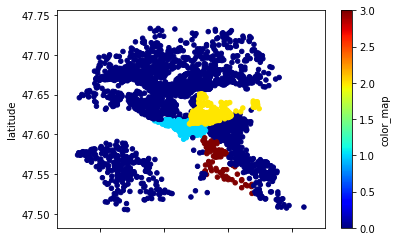

In [105]:
n_best = 3
plot_best_neighborhoods(listings_df, n_best)

### What are the busiest months for renters?

Here we may produce 2 distributions:
1. number of bookings by month
2. estimated revenues by month

To get the first distribution, we can use `reviews_df`, group the data by month and count records in each group

In [106]:
bookings_by_month = reviews_df['date'].groupby(reviews_df['date'].dt.month).count()

Representing this series by bar plot helps to see the evident trend: second half of the summer and early fall are the busies seasons for hosts

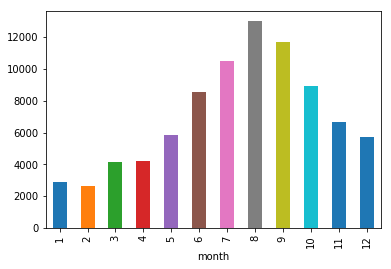

In [107]:
bookings_by_month.index.names =  ['month']
bookings_by_month.plot.bar();

To get the distrubution of estimated revenues by month, we can use the columns `date` and `estimated_revenue` from `bookings_df`dataframe. 
Group by month in `data` and compute sum in each group   

In [108]:
revenue_by_month = bookings_df[['date','estimated_revenue']].groupby(bookings_df["date"].dt.month).sum()
revenue_by_month

,estimated_revenue
date,
1,615071.0
2,737003.0
3,1073391.0
4,1028092.0
5,1755773.0
6,1991564.0
7,2425408.0
8,3153118.0
9,2818165.0


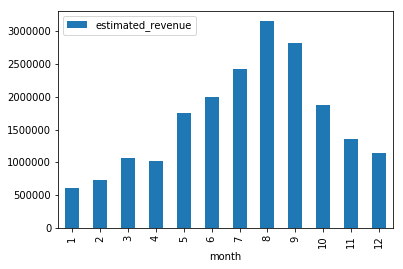

In [110]:
revenue_by_month.index.names =  ['month']
revenue_by_month.plot.bar();

We see that estimated revenues are also maximal in the same period as the number of bookings: second half of the summer and early fall. 

###  Predicting Listing Price

Target variable is `price`, explanatory variables are stored in `features_df` DataFrame.

Let's check covariation matrix for `price` and several "objective" numerical properties of a listing
("objective" means it does not depends on somebody's evaluation, like number of bedrooms or bathrooms)

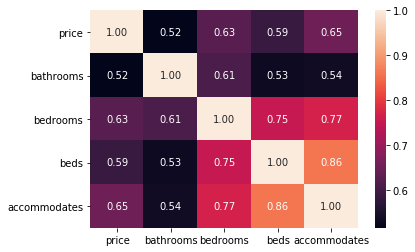

In [111]:
sns.heatmap(listings_df[['price', 'bathrooms', 'bedrooms', 'beds','accommodates']].corr(), annot=True, fmt=".2f");


The numbers in the first column show that there is a strong correlation between `price` and the chosen explanatory variables. They are already included in `features_df` dataframe explanatory variables, together with one-hot encoded categorical variable `neighbourhood_group_cleansed`.

So I will try to use the simple Linear Regression model.

For intialization, fitting and evaluating the model, I will define a new function.

In [114]:
# Building and estimating the linear regression model
def build_lr_model(X, y):
    '''
    INPUT: 
    X - dataframe with explanatory variables (features)
    y - series containing target variable
        
    OUTPUT:
    rsquared_score_train - rsquared score for train data
    rsquared_score_test - rsquared score for test data
    lm_model - trained linear regression model 
    '''
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state=42) 
       
    # Init the model
    lm_model = LinearRegression(normalize=True)
    # Fit using training data
    lm_model.fit(X_train, y_train)

    # Estimate preformance using Rsquared metrics
    y_train_preds = lm_model.predict(X_train) 
    y_test_preds  = lm_model.predict(X_test)

    rsquared_score_train = r2_score(y_train, y_train_preds)  
    rsquared_score_test  = r2_score(y_test, y_test_preds)  
    
    return rsquared_score_train, rsquared_score_test, lm_model 



Lets use the defined function with the prepared data

In [115]:
rsquared_score_train, rsquared_score_test, lr_model = build_lr_model(features_df, listings_df['price'])

print("The r-squared train score for linear model is {}".format(rsquared_score_train))
print("The r-squared test  score for linear model is {}".format(rsquared_score_test))


The r-squared train score for linear model is 0.528688938866531
The r-squared test  score for linear model is 0.5351489467426445


# Evaluate the Results

We were able to introduce an meaningful Estimated Revenue metric and get some important insight from Seattle AirBnB data:

- Seattle neighbourhoods are ranked for the prospective hosts with relation to estimated revenue. Three central neighbourhoods (Downtown, Capitol Hill, Beacon Hill) can provide highest revenue. 

- Distribution of revenue by month showes that late summer and early fall are busiest months. The property maintenance should be better done from late fall to early spring.   

Also we created and trained a simple Linear Regression model which can be used for helping the prospective buyers to estimate the rental price of their property, using several property features (number of bedrooms, bathrooms, beds; how many peoples can be accomodated) and the neighbourhood, where the property is located. 

We see that our model has a moderate predicing capability: r-squared ~ 0.5, wich is far from perfect 1.0. Apparently the `neighbourhood_group_cleansed` is too coarse characteristic: in one neighborhood the variation in price can be significant. Probably the model can be improved if we take into account the property description. 

On the good side: metrics for train and test data are quite similar, which means that we avoided the overfitting and do not need any regularization.
